In [34]:
from PIL import Image

# Theory

### Row LSTM
1. the input-to-state is first computed for the entire two-dimensional input map  
  a. a k × 1 convolution is used to follow the row-wise orientation of the LSTM itself  
  b. the convolution is masked to include only the valid context  
  c. produces a tensor of size 4h × n × n (4*num_lstm_units, height, width) representing the four gate vectors for each position in the input map
2. the one step of the state-to-state component of the LSTM layer computation:  
  a. given the previous hidden and cell states $h_{i-1}$ and $c_{i-1}$, each of size h × n × 1, the new hidden and cell states $h_i$ , $c_i$ are obtained as follows:  

$$
o_i,f_i, i_i, g_i = \sigma(K_{ss} * h_{i-1} + K_{is} * x_i) \\
c_i = f_i \odot c_{i-1} + i_i \odot g_i \\
h_i = o_i \odot \tanh(c_i)
$$

$$
p(x_i,R|x_{<i})p(x_i,G|x{<i}, x_i,R)p(x_i,B|x_{<i}, x_i,R, x_i,G)
$$

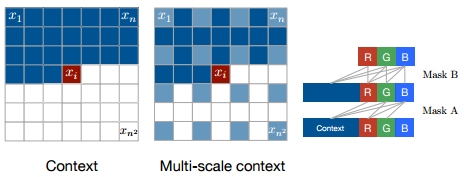

In [5]:
Image.open('./masking.png')

### Context contains only pixels generated left and above!

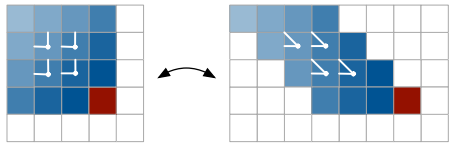

In [6]:
Image.open('./skew.png')

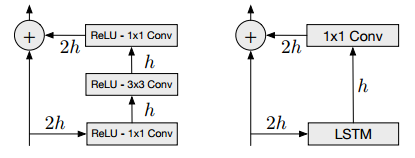

In [7]:
Image.open('./rnn_cnn_units.png')

# Implementation

## Convolutional LSTM Layer

In [1]:
import pixel_lstm
reload(pixel_lstm)
from pixel_lstm import PixelLSTMLayer # PixelLSTMCell
from lasagne.layers import InputLayer

import numpy as np
import lasagne
import theano

n_batch, n_channels, height, width, num_units = 10, 3, 28, 55, 64

l_inp = InputLayer((None, n_channels, height, width))
pixel_rnn_lstm_cell = PixelLSTMLayer(l_inp, num_units=num_units, precompute_input=True)

pixel_lstm_out = lasagne.layers.get_output(pixel_rnn_lstm_cell)

Using gpu device 0: GeForce GTX 970M (CNMeM is disabled, cuDNN 5005)


In [ ]:
# import theano.tensor as T
# hidInit = T.unbroadcast(lasagne.utils.create_param(lasagne.init.Constant(0.), (1, 64, 28)), 0)
# hidInit.eval().shape
# np.tensordot(np.random.rand(5,1), np.random.rand(1, 64, 28), axes=[1,0]).shape
# T.tensordot(T.ones((5, 1)), hidInit, axes=[1,0]).eval().shape
# l_inp.input_var.broadcastable

In [2]:
pixel_rnn_lstm_cell.output_shape

[None, 64, 28, 55]

In [4]:
# test
pixel_rnn = theano.function([l_inp.input_var], pixel_lstm_out, allow_input_downcast=True)
pixel_rnn(np.random.rand(5, 3, 28, 55)).shape

(5, 64, 28, 55)

In [5]:
pixel_rnn_lstm_cell.cell_init.get_value(borrow=True).shape

(1, 64, 55)

## PixelRNN stack

In [7]:
from collections import OrderedDict
from lasagne.layers import InputLayer, NonlinearityLayer
import pixel_rnn
reload(pixel_rnn)
from pixel_rnn import *

import numpy as np
import lasagne
import theano
import theano.tensor as T

In [6]:
input_shape = (3, 28, 28)
pixel_rnn = OrderedDict()
pixel_rnn['input'] = InputLayer((None, ) + input_shape)
pixel_rnn['input_conv'] = Conv2DLayer(pixel_rnn.values()[-1], num_filters=64, filter_size=7, name='input_conv')
pixelrnn_block = build_pixelrnn_block(pixel_rnn.values()[-1], 0, (32, 'A'), connected=False)
pixel_rnn.update(pixelrnn_block)

TypeError: build_pixelrnn_block() got multiple values for keyword argument 'connected'

In [8]:
pixel_rnn, out_l = build_pixel_nn(dataset='mnist', type='rnn')

In [9]:
(pixel_rnn.values()[-1].output_shape)

(None, 256, 22, 22)

In [10]:
pixel_rnn_fn = theano.function([pixel_rnn['input'].input_var], lasagne.layers.get_output(pixel_rnn.values()[-1]))

In [12]:
pixel_rnn_fn(np.random.rand(5, 1, 28, 28).astype('float32')).shape

(5, 256, 22, 22)

In [42]:
input_shape = (3, 28, 28)
pixel_cnn = OrderedDict()
pixel_cnn['input'] = InputLayer((None, ) + input_shape)
pixel_cnn['input_conv'] = Conv2DLayer(pixel_cnn.values()[-1], num_filters=64, filter_size=7, name='input_conv')
pixel_cnn_block = build_pixelcnn_block(pixel_cnn.values()[-1], 0)
pixel_cnn.update(pixel_cnn_block)

[(None, 64, 22, 22), (None, 64, 22, 22)]


In [3]:
pixel_cnn, out_l = build_pixel_nn(dataset='mnist', type='cnn')

[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]
[(None, 256, 22, 22), (None, 256, 22, 22)]


In [11]:
lasagne.layers.get_output(out_l, deterministic=True)

TypeError: get_output_for() got an unexpected keyword argument 'deterministic'

In [5]:
# (pixel_cnn_block.values()[-1].output_shape)

In [6]:
(pixel_cnn.values()[-1].output_shape)

(None, 256, 22, 22)

In [7]:
pixel_cnn_fn = theano.function([pixel_cnn['input'].input_var], lasagne.layers.get_output(pixel_cnn.values()[-1]))

In [8]:
pixel_cnn_fn(np.random.rand(5, 1, 28, 28).astype('float32')).shape

(5, 256, 22, 22)

In [48]:
%pdef NonlinearityLayer

Class constructor information:
 NonlinearityLayer(self, incoming, nonlinearity=<function rectify at 0x7f0d9bec95f0>, **kwargs)
 

In [14]:
import sys
sys.path.append('..')

In [65]:
import os
import numpy as np
import lasagne
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
import pixel_nn_utils
reload(pixel_nn_utils)
from pixel_nn_utils import load_data

In [66]:
def binarize(images):
    """
    Stochastically binarize values in [0, 1] by treating them as p-values of
    a Bernoulli distribution.
    """
    return (np.random.uniform(size=images.shape) < images).astype('float32')

In [30]:
ds = load_data(False, 'MNIST', os.path.join(os.path.expanduser('~'), 'Data'))

In [39]:
np.histogram(ds['X_train'][0])

(array([639,  11,   6,  11,   6,   9,  11,  12,  11,  68]),
 array([ 0.        ,  0.09960938,  0.19921875,  0.29882812,  0.3984375 ,
         0.49804688,  0.59765625,  0.69726562,  0.796875  ,  0.89648438,
         0.99609375]))

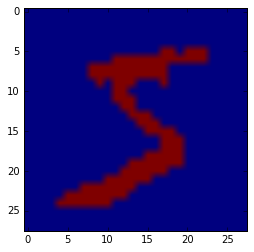

In [71]:
plt.imshow(ds['X_train'][0].reshape(28, -1) > 0.5)

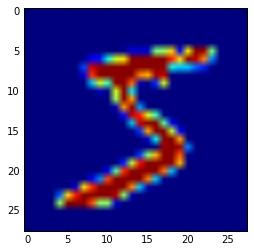

In [70]:
plt.imshow(ds['X_train'][0].reshape(28, -1))

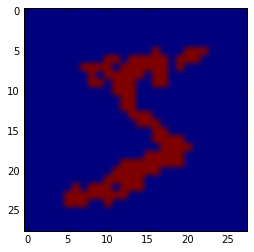

In [69]:
plt.imshow(binarize(ds['X_train'][0]).reshape(28, -1))

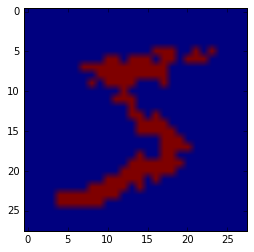

In [77]:
plt.imshow(np.random.binomial(n=1, p=ds['X_train'][0].reshape(28, -1)))

In [ ]:
def generate_and_save_samples(tag):

    def save_images(images, filename):
        """
        images.shape: (batch, height, width, channels)
        """
        images = images.reshape((10,10,28,28))
        # rowx, rowy, height, width -> rowy, height, rowx, width
        images = images.transpose(1,2,0,3)
        images = images.reshape((10*28, 10*28))

        scipy.misc.toimage(images, cmin=0.0, cmax=1.0).save('{}_{}.jpg'.format(filename, tag))

    samples = numpy.zeros((100, HEIGHT, WIDTH, 1), dtype='float32')

    for i in xrange(HEIGHT):
        for j in xrange(WIDTH):
            for k in xrange(N_CHANNELS):
                next_sample = binarize(sample_fn(samples))
                samples[:, i, j, k] = next_sample[:, i, j, k]

    save_images(samples, 'samples')

## Conditional PixelRNN